#### Importing all packages required for the different functions

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec 
from scipy import signal
import pandas as pd
import math #this needs to be changes so that math is not required. Should be using numpy only

%matplotlib inline

# AVO and AVO Analysis Basics

This walktrough assumes some introductory knowledge of the seismic experiement and zero-incident/offset seismic concepts. It attemps to expands upon that concept by explaining, with examples, the significance of amplitude changes at incident angles greater than zero. This topic (as well as the more simple zero-incident case) is explained simply but succinctly by Matt Hall of agilegeoscience here: https://agilescientific.com/blog/2011/6/6/what-is-avo.html

The basics, however are as follows: "The basic physics behind AVO analysis is that the strength of a reflection does not only depend on the acoustic impedance—it also depends on the angle of incidence."$^{[1]}$  

Analysis of AVO, or amplitude variation with offset, seeks to extract rock parameters (velocity, density, etc.) by analyzing seismic amplitude as a function of offset, or more correctly as a function of reflection angle.

The reflection coefficient for plane elastic waves as a function of reflection angle at a single interface is described by the complicated Zoeppritz equations (Zoeppritz 1919). The analysis of P-wave reflections, a well-known approximation is given by Aki and Richards (1980), assuming weak layer contrasts.$^{[2]}$ These equations, their meaning, and their importance will be discussed below.

${[1]}$ https://agilescientific.com/blog/2011/6/6/what-is-avo.html  
${[2]}$ Avseth, Per; Mukerji, Tapan; Mavko, Gary. Quantitative Seismic Interpretation: Applying Rock Physics Tools to Reduce Interpretation Risk (Kindle Location 3990). Cambridge University Press. Kindle Edition. 

### Knott-Zoeppritz matrix representation (from Castanga and Backus 1993)

Below is the vectorized matrix representation of the Knott-Zoeppritz equations such that $Q = P^{-1} R$

The Zoepprittz equations describe how energy is partitioned at an interface. While accurate, these equations do not provide a very intuitive physical understanding of how reflection varies with rock properties. There are several approximations to the Zoeppritz equations which attempt to show which physical properties of rocks control reflection varaitions most directly. These will be introduced below the Zoeppritz equations.

##### From Castagna and Backus 1993: 

For an interface between two infinite elastic half-spaces, there are sixteen reflection and transmission coefficients. In the Aki and Richards notation, the coefficients are represented by two letters (e.g. $\grave{P}\acute{S}$). The first letter indicates the type of incident wave and the second letter represents the type of derived wave. The acute acent indicates an upgoing wave while a downgoing wave has a grave accent. Thus, $\grave{P}\acute{S}$ is the downgoing P-wave to the upgoing S-wave coefficient. With this notation, the scattering matrix is:
    
  $$ 
   Q=
  \left[ {\begin{array}{cccc}
   \grave{P}\acute{P} & \grave{S}\acute{P} & \acute{P}\acute{P} & \acute{S}\acute{P} \\
   \grave{P}\acute{S} & \grave{S}\acute{S} & \acute{P}\acute{S} & \acute{S}\acute{S} \\
   \grave{P}\grave{P} & \grave{S}\grave{P} & \acute{P}\grave{P} & \acute{S}\grave{P} \\   
   \grave{P}\grave{S} & \grave{S}\grave{S} & \acute{P}\grave{S} & \acute{S}\grave{S} \\       
  \end{array} } \right]
     = P^{-1}R
  $$
  
  $$Where:$$ 

 $$ 
   P= \left[ {\begin{array}{cccc}
   -sin\ \theta_1 & -cos\ \phi_1 & sin\ \theta_2 & cos\ \phi_2 \\
   cos\ \theta_1 & -sin\ \phi_1 & cos\ \theta_2 & -sin\ \phi_2 \\
   2 \rho_1 V_{s1} sin\ \phi_1 cos\ \theta_1 & \rho_1 V_{s1}(1 - 2sin^2 \phi_1) & 2\rho_2 V_{s2} sin\ \phi_2 cos\ \theta_2 & \rho_2 V_{s2} (1-2sin^2\ \phi_2)\\ 
   -\rho V_{p1} (1-2sin^2\ \phi_1) & \rho_1 V_{s1} sin\ 2\phi_1 & \rho_2 V_{p2}(1-2 sin^2\ \phi_2) & -\rho_2V_{p2} sin2\ \phi_2
  \end{array} } \right]   
  $$
  
  $$and$$
  
  $$
     R=
  \left[ {\begin{array}{cccc}
   sin\ \theta_1 & cos\ \phi_1 & -sin\ \theta_2 & -cos\ \phi_2 \\
   cos\ \theta_1 & -sin\ \phi_1 & cos\ \theta_2 & -sin\ \phi_2 \\
   2 \rho_1 V_{s1} sin\ \phi_1 cos\ \theta_1 & \rho_1 V_{s1}(1 - 2sin^2 \phi_1) & 2\rho_2 V_{s2} sin\ \phi_2 cos\ \theta_2 & \rho_2 V_{s2} (1-2sin^2\ \phi_2)\\ 
   \rho V_{p1} (1-2sin^2\ \phi_1) & -\rho_1 V_{s1} sin\ 2\phi_1 & -\rho_2 V_{p2}(1-2 sin^2\ \phi_2) & \rho_2V_{p2} sin2\ \phi_2
  \end{array} } \right] 
  $$

Parameters are defined here

Format for vp,vs,rho is:  
$V_p,V_s,\rho = ([[V_p\ Layer\ 1, V_p\ Layer\ 2],[V_s\ Layer\ 1, V_s\ Layer\ 2],[\rho\ Layer\ 1, \rho\ Layer\ 2]])$


In [34]:
theta = 20
vp,vs,rho = ([[2468,2600],[1006,1700],[2250,1850]])
#vp,vs,rho = ([[2468,2600],[1006,1700],[2250,1850]]) #defaults

vs1=vs[0]; vs2=vs[1]    
vp1=vp[0]; vp2 = vp[1]    
rho1=rho[0]; rho2=rho[1] 
#theta1 = range(91)

Zoeppritz scattering matrix defined below:

In [35]:
def zoeppritz(vp,vs,rho,theta):

    theta1 = np.radians(theta).astype(complex)
    vs1=vs[0]; vs2=vs[1]    
    vp1=vp[0]; vp2 = vp[1]    
    rho1=rho[0]; rho2=rho[1]
    p = np.sin(theta1) / vp1 # ray parameter p
    theta2 = np.arcsin(p*vp2)
    phi1= np.arcsin(p*vs1)
    phi2 = np.arcsin(p*vs2)

    P = np.array([[-np.sin(theta1), -np.cos(phi1), np.sin(theta2), np.cos(phi2)],
              [np.cos(theta1), -np.sin(theta1), np.cos(theta2), -np.sin(phi2)], 
              [2*rho1*vs1*np.sin(phi1)*np.cos(theta1), rho1*vs1*(1-2*np.sin(phi1)**2), 
               2*rho2*vs2*np.sin(phi2)*np.cos(theta2), rho2*vs2*(1-2*np.sin(phi2)**2)],
              [-rho1*vp1*(1-2*np.sin(theta1)**2), rho1*vs1*np.sin(2*phi1),
               rho2*vp2*(1-2*np.sin(phi2)**2),-rho2*vs2*np.sin(2*phi2)]])

    R = np.array([[np.sin(theta1), np.cos(phi1), -np.sin(theta2), -np.cos(phi2)],
              [np.cos(theta1), -np.sin(phi1), np.cos(theta2), -np.sin(phi2)],
              [2*rho1*vs1*np.sin(phi1)*np.cos(theta1), rho1*vs1*(1-2*np.sin(phi1)**2),
               2*rho2*vs2*np.sin(phi2)*np.cos(theta2), rho2*vs2*(1-2*np.sin(phi2)**2)],
              [rho1*vp1*(1-2*np.sin(theta1)**2), -rho1*vs1*np.sin(2*phi1),
               -rho2*vp2*(1-2*np.sin(phi2)**2),rho2*vs2*np.sin(2*phi2)]])

    Q = np.linalg.inv(P)*R
    
    return Q

In [36]:
print('The real components of the scattering matrix for a wave incident at ' 
      + str(theta) + ' degrees: ' + '\n'+ '\n'+ str(np.real(zoeppritz(vp,vs,rho,theta)))) 
      

The real components of the scattering matrix for a wave incident at 20 degrees: 

[[ -5.22767437e-02   4.90518225e-01  -1.41594602e-08   1.04850407e-07]
 [ -4.97126715e-01   2.60655992e-02   1.69617308e-07  -6.26297723e-09]
 [  3.80415868e+04   9.95362743e+05   9.77861241e-02   2.95736786e-01]
 [  1.75408584e+06   1.16119407e+05  -7.39215305e-01  -7.21473909e-02]]



Recall:
  $
   Q=
  \left[ {\begin{array}{cccc}
   \grave{P}\acute{P} & \grave{S}\acute{P} & \acute{P}\acute{P} & \acute{S}\acute{P} \\
   \grave{P}\acute{S} & \grave{S}\acute{S} & \acute{P}\acute{S} & \acute{S}\acute{S} \\
   \grave{P}\grave{P} & \grave{S}\grave{P} & \acute{P}\grave{P} & \acute{S}\grave{P} \\   
   \grave{P}\grave{S} & \grave{S}\grave{S} & \acute{P}\grave{S} & \acute{S}\grave{S} \\       
  \end{array} } \right]
     = P^{-1}R
  $

### Zoeppritz Rpp and Rps from Aki Richards, 1980 derivation
#### Restated in Lu et al., 2015 *Joint PP and PS AVA seismic inverson using the exact Zoeppritz equations*

These are linear represetnations of the Zoepprittz equations for $\grave{P}\acute{P}$ and $\grave{P}\acute{S}$ waves. This allows for an array to be passed to a zoeppritz solver, rather than a single value for theta which we must then iterate over.

https://doi.org/10.1190/geo2014-0490.1


In [37]:
#Full Zoeppritz Rpp and Rps from Aki and Richards 1980 derivation
def zoeRppRps(vp,vs,rho,thetaMax):    
    theta1 = np.radians(np.arange(thetaMax)).astype(complex)
    p = np.sin(theta1) / vp1  # Ray parameter
    theta2 = np.arcsin(p * vp2)
    phi1 = np.arcsin(p * vs1)  # Reflected S
    phi2 = np.arcsin(p * vs2)  # Transmitted S

    a = rho2 * (1 - 2 * np.sin(phi2)**2.) - rho1 * (1 - 2 * np.sin(phi1)**2.)
    b = rho2 * (1 - 2 * np.sin(phi2)**2.) + 2 * rho1 * np.sin(phi1)**2.
    c = rho1 * (1 - 2 * np.sin(phi1)**2.) + 2 * rho2 * np.sin(phi2)**2.
    d = 2 * (rho2 * vs2**2 - rho1 * vs1**2)

    E = (b * np.cos(theta1) / vp1) + (c * np.cos(theta2) / vp2)
    F = (b * np.cos(phi1) / vs1) + (c * np.cos(phi2) / vs2)
    G = a - d * np.cos(theta1)/vp1 * np.cos(phi2)/vs2
    H = a - d * np.cos(theta2)/vp2 * np.cos(phi1)/vs1

    D = E*F + G*H*p**2

    Rpp = (1/D) * (F*(b*(np.cos(theta1)/vp1) - c*(np.cos(theta2)/vp2)) \
                   - H*p**2 * (a + d*(np.cos(theta1)/vp1)*(np.cos(phi2)/vs2)))

    Rps = (1/(vs1*D)) * (-2*(np.cos(theta1)/vp1) * (a*b + c*d*((np.cos(theta2)*np.cos(phi2))/(vp2*vs2))*p*vp1))
    
    return Rpp, Rps


# Approximations to the Zoeppritz Equations

#### Aki-Richards

From Avesth et al., 2006 *Quantitative seismic interpretation*  

Aki and Richards simplified the Zoeppritz equations by assuming only small changes in elastic properties across the reflection interface. This simplification makes it easier to see the effects of changing velocities and density.

$$R(\theta) = W - X \sin^2 \theta + Y \frac{1}{\cos^2 \theta_\mathrm{avg}} - Z \sin^2 \theta $$

$$W = \frac{1}{2} \frac{\Delta \rho}{\rho}\ ,\
X = 2 \frac{V^2_\mathrm{S}}{V^2_\mathrm{P1}} \frac{\Delta \rho}{\rho}\ ,\
Y = \frac{1}{2} \frac{\Delta V_\mathrm{P}}{V_\mathrm{P}}\ ,\
Z = 4 \frac{V^2_\mathrm{S}}{V^2_\mathrm{P1}} \frac{\Delta V_\mathrm{S}}{V_\mathrm{S}}$$

$$\text{Where the delta expressions are, for example:}$$

$$\frac{\Delta \rho}{\rho} = \frac{\rho_2 - \rho_1}{(\rho_1 + \rho_2)/2}$$


An important parameter here which is not present in the other approximations is the $\theta_{avg}$ parameter. It is the mean of the incident and transmission angles, often approximated as the incidence angle, but calcualted exactly in this implementation. 

##### Define parameters for a two layer model

In [38]:
thetaMax = 91

Aki-Richards approximation implementation

In [39]:
def akiRich(vp,vs,rho,thetaMax):
    
    dvp = vp[1]-vp[0]
    dvs = vs[1]-vs[0]
    drho = rho[1]-rho[0]
    vpav = np.mean(vp)
    vsav = np.mean(vs)
    rhoav = np.mean(rho)
    theta = np.radians(np.arange(thetaMax)).astype(complex)
    thetaTransmitted = np.arcsin(vp2/vp1*np.sin(theta))
    thetaAvg = (theta+thetaTransmitted)/2
    
    W = 0.5*(drho/rhoav)
    X = 2*(vsav/vp1)**2 * (drho/rhoav)
    Y = 0.5*(dvp/vpav)
    Z = 4*(vsav/vp1)**2 * (dvs/vsav)
    
    akiRich = W - X * np.sin(theta)**2 + Y*(1/np.cos(thetaAvg)**2) - Z*np.sin(theta)**2
    
    return akiRich

#### Shuey Approximation and Equation (2-term and 3-term)


##### From Shuey, 1985:

Although the four Zoeppritz equations can be solved for the four unknowns, they do not give an intuitive understanding for how the reflection amplitudes vary with the rock properties involved (density, velocity etc.). The Shuey equation, and approximation, furtther modify the Zoeppritz equations by assuming that Poissons' ratio is the property most directly related to the change of reflection coefficient with incidence angle.

$$\textbf{Two-term Approximation:}$$

$$R(\theta ) \approx R(0) + G \sin^2 \theta$$

$$where$$

$$R(0) = \frac{1}{2} \left ( \frac{\Delta V_\mathrm{P}}{V_\mathrm{P}} + \frac{\Delta \rho}{\rho} \right )\ and\ G = \frac{1}{2} \frac{\Delta V_\mathrm{P}}{V_\mathrm{P}} - 2 \frac{V^2_\mathrm{S}}{V^2_\mathrm{P}} \left ( \frac{\Delta \rho}{\rho} + 2 \frac{\Delta V_\mathrm{S}}{V_\mathrm{S}}  \right )$$

$$\textbf{Three-term Equation:}$$

$$R(\theta ) = R(0) + G \sin^2 \theta + F ( \tan^2 \theta - \sin^2 \theta )$$

$$where$$ 

$$F = \frac{1}{2}\frac{\Delta V_\mathrm{P}}{V_\mathrm{P}}$$

From Avseth et al., 2006 *Quantitative seismic interpretation*

In [40]:
def shuey(vp,vs,rho,thetaMax):
    
    dvp = vp[1]-vp[0]
    dvs = vs[1]-vs[0]
    drho = rho[1]-rho[0]
    vpav = np.mean(vp)
    vsav = np.mean(vs)
    rhoav = np.mean(rho)
    theta = np.radians(np.arange(thetaMax)).astype(complex)
    
    #2-term approximation
    R0 = 0.5*(dvp/vpav + drho/rhoav)
    G = 0.5*(dvp/vpav) - 2*(vsav**2/vpav**2)*(drho/rhoav + 2*(dvs/vsav))
    
    #3-term shuey equation
    F = 0.5*(dvp/vpav)
    
    shuey2 = R0 + G*np.sin(theta)**2
    shuey3 = R0 + G*np.sin(theta)**2 + F*(np.tan(theta)**2 - np.sin(theta)**2)
    
    return shuey2, shuey3


#### Intercept and Gradient

AVO Intercept and Gradient refer either to terms in the linearized AVO equations or to the equivalent measurements from seismic data. Wiggins et al (1983) rearranged the Aki & Richards (1980) linearization of the Zoeppritz equations to obtain:

$$R(\theta) \approx A + B\sin^{2}\theta + C\sin^{2}\theta\tan^{2}\theta$$

$$A = \frac{1}{2}(\frac{\Delta V_{P}}{V_{P}}+\frac{\Delta\rho}{\rho})\,\,\,\,\,\,\,\,B = \frac{\Delta V_{P}}{2V_{P}} - 4k(\frac{\Delta V_{S}}{V_{S}}) - 2k(\frac{\Delta \rho}{\rho})\,\,\,\,\,\,\,\,C = \frac{\Delta V_{P}}{2V_{P}}$$

$A$ is referred to as the intercept, $B$ the gradient and $C$ the curvature term.

##### This notation is not consistent throughout literature and it therefore recommended that you instead use the more publication consistent nomenclature of the three-term Shuey euqation, restated below.

$$R(\theta ) = R(0) + G \sin^2 \theta + F ( \tan^2 \theta - \sin^2 \theta )$$

$$R(0) = \frac{1}{2} \left ( \frac{\Delta V_\mathrm{P}}{V_\mathrm{P}} + \frac{\Delta \rho}{\rho} \right )\,\,\,\,\,\,\,\,G = \frac{1}{2} \frac{\Delta V_\mathrm{P}}{V_\mathrm{P}} - 2 \frac{V^2_\mathrm{S}}{V^2_\mathrm{P}} \left ( \frac{\Delta \rho}{\rho} + 2 \frac{\Delta V_\mathrm{S}}{V_\mathrm{S}}  \right )\,\,\,\,\,\,\,F = \frac{1}{2}\frac{\Delta V_\mathrm{P}}{V_\mathrm{P}}$$

Where $R(0)$ is the intercept, or normal-incident reflection coefficient.  
$G$ is the gradient, describing variations in the intermediate offsets up to ~ 30 degrees.  
$F$ is the curvature and dominates the far offsets, near the critical angle. 

##### Below we will calcualte the intercept, gradient, and curvature, though we won't be using curvature in the following examples. We will then add noise to the original point in order to simulate what you might see in real, noisy data. 

Since intercept ($R(0)$) and gradient ($G$) calculations on real data come from least-squares linear regressions of $sin^2\theta$ vs amplitude vs. there will be a negative correlation between them. Lager intercepts are correlated with smaller slopes for a given data set. Hence, uncorrelated random noise will show an oval, correlated distribution in the $R(0)$ - $G$ cross-plot.$^{[1]}$ 
 

In [41]:
def igc(vp,vs,rho,thetaMax):
    dvp = vp[1]-vp[0]
    dvs = vs[1]-vs[0]
    drho = rho[1]-rho[0]
    vpav = np.mean(vp)
    vsav = np.mean(vs)
    rhoav = np.mean(rho)
    theta = np.radians(np.arange(thetaMax)).astype(complex)


    intercept = 0.5*(dvp/vpav + drho/rhoav) #Note that this is the same as the zero incidence/zero offset reflection  
    gradient = 0.5 * (dvp/vpav) - 2*(vsav/vpav)**2 * (drho/rhoav + 2* dvs/vsav)
    curvature = 0.5*(dvp/vpav)
    
    return intercept, gradient, curvature


Compute the intercept, gradient, and curvature of the two layer model defined above. Additionally, generate some fake data correlated in IG-space to simulate noise.

In [42]:
intercept, gradient, curvature = igc(vp,vs,rho,thetaMax)

#Make some fake data by adding some random noise
means = [np.mean(intercept), np.mean(gradient)]
stds = [0.05,0.05]
corr = -0.75 #correlation
covs = [[stds[0]**2, stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr, stds[1]**2]]
noiseTrend = np.random.multivariate_normal(means, covs, 70).T

##### Plotting happens here

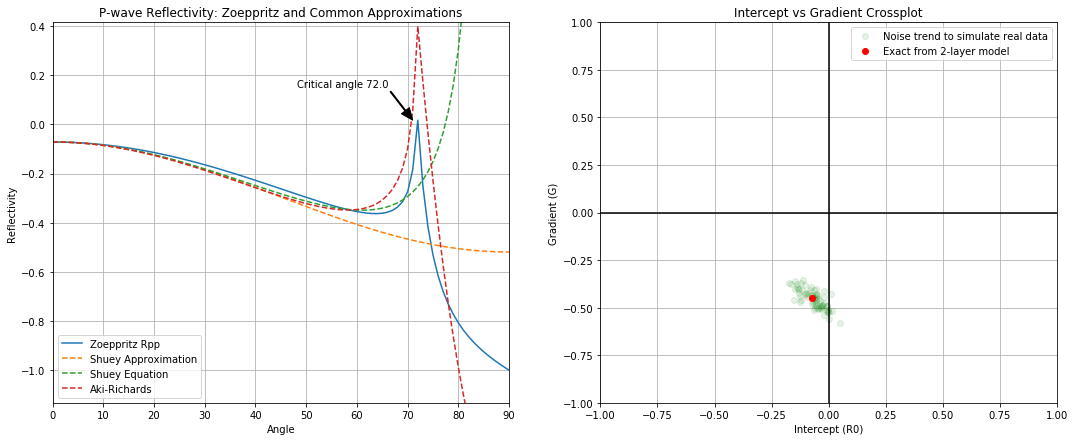

In [43]:
Rpp,Rps = zoeRppRps(vp,vs,rho,thetaMax)
shuey2,shuey3 = shuey(vp,vs,rho,thetaMax)
aki = akiRich(vp,vs,rho,thetaMax)

xcrit = np.gradient(np.real(Rpp)).argmax()
ycrit = np.max(np.real(Rpp))
critAngle = 100
if vp[0]/vp[1] <= 1:
    critAngle = np.degrees(np.arcsin(vp[0]/vp[1]))
    
#Plotting 
plt.figure(figsize=(18,7))
ax1 = plt.subplot(121)
ax1.plot(np.real(Rpp),label = 'Zoeppritz Rpp')
#ax1.plot(np.real(Rps), label = 'Zoeppritz Rps')
ax1.plot(np.real(shuey2), '--', label = 'Shuey Approximation')
ax1.plot(np.real(shuey3), '--', label = 'Shuey Equation')
ax1.plot(np.real(aki),'--', label = 'Aki-Richards')
ax1.set_xlim(0,thetaMax-1)
ax1.set_ylim(np.min(np.real(Rpp))-(np.std(np.real(Rpp))*0.5),np.max(np.real(Rpp))+(np.std(np.real(Rpp)))*1.5)
#plt.ylim(-1,1)
ax1.set_xlabel('Angle')
ax1.set_ylabel('Reflectivity')
ax1.set_title('P-wave Reflectivity: Zoeppritz and Common Approximations')
if thetaMax > critAngle:
    ax1.annotate('Critical angle ' + str(np.round(critAngle,0)), xy = (xcrit,ycrit), 
                 xytext = (xcrit-(thetaMax/4),ycrit+(np.std(np.real(Rpp))/2)), 
                 arrowprops=dict(facecolor='black', width = 1, headwidth = 10),
                )        
#ax1.plot(np.gradient(Rpp))
ax1.legend()
ax1.grid()

ax2 = plt.subplot(122)
ax2.plot(noiseTrend[0],noiseTrend[1],'go',alpha = 0.1, label = 'Noise trend to simulate real data')
ax2.plot(intercept,gradient,'ro', label = 'Exact from 2-layer model')
ax2.set_xlim(-1,1)
ax2.set_ylim(-1,1)
ax2.set_xlabel('Intercept (R0)')
ax2.set_ylabel('Gradient (G)')
ax2.set_title('Intercept vs Gradient Crossplot')
ax2.axvline(x=0,color = 'k')
ax2.axhline(y=0,color = 'k')
ax2.legend()
ax2.grid()




# AVO Classes

AVO classes were originally defined for where the top of a gas sand sits in a $R(0)$ and $G$ cross-plot. Three main classes were defined by Rutherford and Williams (1989), with other class definitions being added later by Castanga and Smith, 1994 and Ross and Kinman, 1995.  

Today the AVO class system is used to describe the character of anomalies which may not necessarily be gas sands. It is suggsted that you apply the the classification names only as a description of the observed anomaly, without infering anything about the lithology or fluid fill.

Below are generalized plots of different AVO anomalies in $sin^2(\theta)$ vs reflectivity space, as well as where those anomalies plot in the corresponding $R(0)$ - $G$ space.

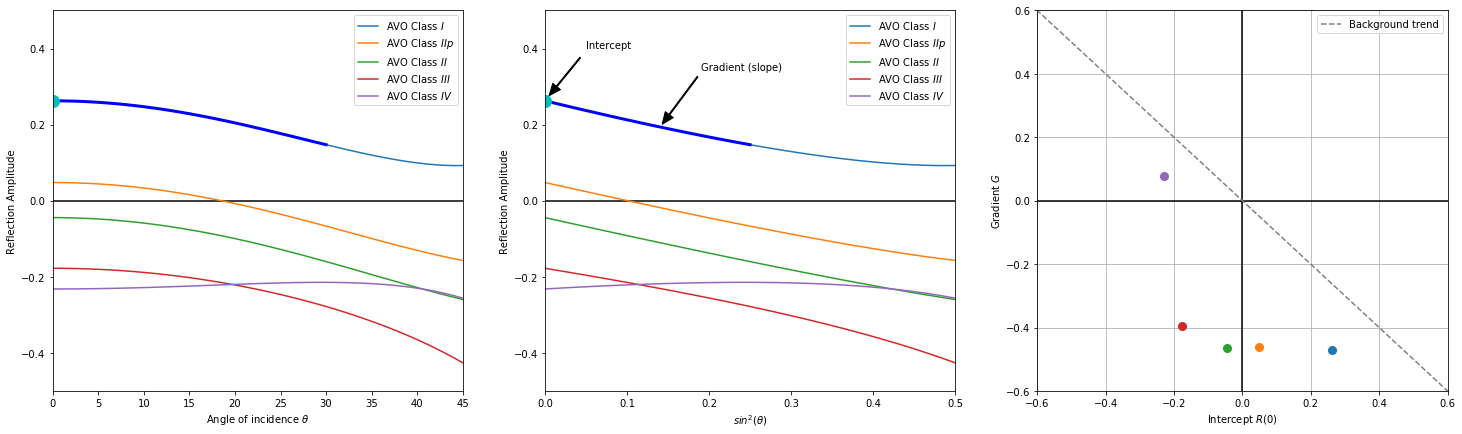

In [44]:
#No need to edit this portion

exampleTheta = 46
avo1 = akiRich([2800,3800],[2000,2250],[2000,2500],exampleTheta)
avo2 = akiRich([2400,2600],[1000,1700],[2250,1900],exampleTheta)
avo2p = akiRich([2300,2600],[1006,1650],[1900,1850],exampleTheta)
avo3 = akiRich([3300,2600],[1700,2000],[2250,2000],exampleTheta)
avo4 = akiRich([3500,2600],[2000,1950],[2250,1900],exampleTheta)

# Only want to calc G over linear portion
AVOclasses = np.array([[avo1[:31]],[avo2p[:31]],[avo2[:31]],[avo3[:31]],[avo4[:31]]]) 

plt.figure(figsize= (25,7))


sintheta2 = np.sin(np.radians(np.arange(0, exampleTheta)))**2
sintheta2 = sintheta2.reshape((exampleTheta, 1))

sintheta2lim30 = np.sin(np.radians(np.arange(0, 31)))**2
sintheta2lim30 = sintheta2lim30.reshape((len(sintheta2lim30), 1))

ones = np.ones(len(sintheta2lim30))
ones = ones.reshape((len(sintheta2lim30),1))

X = np.hstack((ones, sintheta2lim30)) 

ax0 = plt.subplot(131)
ax0.axhline(0,color = 'k')
ax0.plot(np.real(avo1),'-',label = r'AVO Class $I$')
ax0.plot(np.real(avo2p),'-',label = r'AVO Class $IIp$')
ax0.plot(np.real(avo2),'-',label = r'AVO Class $II$')
ax0.plot(np.real(avo3),'-',label = r'AVO Class $III$')
ax0.plot(np.real(avo4),'-',label = r'AVO Class $IV$')
ax0.plot(np.arange(31),np.real(avo1[:31]),'b-',linewidth = 3)
ax0.plot(0, np.real(avo1[0]),'co', markersize=12)
ax0.set_ylim(-0.5,0.5)
ax0.set_xlim(0,np.max(exampleTheta-1))
ax0.set_xlabel(r'Angle of incidence $\theta$')
ax0.set_ylabel('Reflection Amplitude')
ax0.legend()

ax1 = plt.subplot(132)
ax1.axhline(0,color = 'k')
ax1.plot(sintheta2,np.real(avo1),'-',label = r'AVO Class $I$')
ax1.plot(sintheta2,np.real(avo2p),'-',label = r'AVO Class $IIp$')
ax1.plot(sintheta2,np.real(avo2),'-',label = r'AVO Class $II$')
ax1.plot(sintheta2,np.real(avo3),'-',label = r'AVO Class $III$')
ax1.plot(sintheta2,np.real(avo4),'-',label = r'AVO Class $IV$')
ax1.plot(sintheta2[:31],np.real(avo1[:31]),'b-',linewidth = 3)
ax1.plot(sintheta2[0], np.real(avo1[0]),'co', markersize=12)
#ax1.plot(sintheta2[30:],np.real(avo1[30:]),'c-',linewidth = 3)
ax1.annotate('Intercept', xy = (0,np.real(avo1[0])),
             xytext = (0.05,0.4), arrowprops=dict(facecolor='black', width = 1, headwidth = 10,shrink = 0.1),
            )
ax1.annotate('Gradient (slope)', xy = (sintheta2[22],np.real(avo1[22])),
             xytext = (sintheta2[22]+0.05,np.real(avo1[22]+0.15)), 
             arrowprops=dict(facecolor='black', width = 1, headwidth = 10, shrink = 0.05),
            )
ax1.set_ylim(-0.5,0.5)
ax1.set_xlim(0,np.max(sintheta2))
ax1.set_xlabel(r'$sin^2(\theta)$')
ax1.set_ylabel('Reflection Amplitude')
ax1.legend()


ax2 = plt.subplot(133)
ax2.axhline(0,color='k')
ax2.axvline(0,color='k')
for i in range(AVOclasses.shape[0]):
    avo = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), AVOclasses[i].T)
    ax2.plot(np.real(avo[0]),np.real(avo[1]),'o', markersize = 8)
ax2.set_xlim(-0.6,0.6)
ax2.set_ylim(-0.6,0.6)
ax2.plot([-1,1],[1,-1],'--', color = 'gray', label = 'Background trend')
ax2.set_xlabel(r'Intercept $R(0)$')
ax2.set_ylabel(r'Gradient $G$')
ax2.legend()
ax2.grid()


# Tuning and AVO

Tuning is interference between the seismic reflections of the top and base of a bed. This interference occurs when a bed is $<1/2$ of a wavelength, with maximum constructive interference at $\frac{\lambda}{4}$ (Widess, 1973). This is called the ***tuning thickness*** and the amplitude becomes larger than the true reflectivity. As the bed thickness decreases below $\frac{\lambda}{4}$, the waves destructively interfere and the amplitude becomes smaller than the real reflectivity.  

A common method for evaluating tuning of a reservoir, and therefore calibration of interpretation, is a wedge model. This is implemented below with a script from Wes Hamlyn of Ikon Geoscience.


**HOW THIN IS A THIN BED?**  
Widess,M. B.  
GEOPHYSICS(1973),38(6):1176  
http://dx.doi.org/10.1190/1.1440403

### Script to generate a zero-offset synthetic from a 3-layer wedge model.

Created by:    Wes Hamlyn  
Create Date:   19-Aug-2014  
Last Mod:      1-Nov-2014  

This script is provided without warranty of any kind.

DEFINE MODELING PARAMETERS HERE

In [45]:
#   3-Layer Model Parameters [Layer1, Layer2, Layer 3]
vp_mod = [4000.0, 3800.0, 4100.0]  # P-wave velocity (m/s)
vs_mod = [1200.0, 1300.0, 1200.0]  # S-wave velocity (m/s)
rho_mod= [2.6, 2.45, 2.6]         # Density (g/cc)

dz_min = 0.0   # Minimum thickness of Layer 2 (m)
dz_max = 60.0  # Maximum thickness of Layer 2 (m)
dz_step= 1.0   # Thickness step from trace-to-trace (normally 1.0 m)


#   Ricker Wavelet Parameters
wvlt_length= 0.128
wvlt_cfreq = 30.0
wvlt_phase = 0.0


#   Trace Parameters
tmin = 0.0
tmax = 0.5
dt = 0.0001 # changing this from 0.0001 can affect the display quality

#   Plot Parameters
min_plot_time = 0.09
max_plot_time = 0.18
excursion = 2

##### Function Definitions

In [46]:
def plot_vawig(axhdl, data, t, excursion, highlight=None):

    import numpy as np
    import matplotlib.pyplot as plt

    [ntrc, nsamp] = data.shape

    t = np.hstack([0, t, t.max()])
    
    for i in range(0, ntrc):
        tbuf = excursion * data[i] / np.max(np.abs(data)) + i
        
        tbuf = np.hstack([i, tbuf, i])
            
        if i==highlight:
            lw = 2
        else:
            lw = 0.5

        axhdl.plot(tbuf, t, color='black', linewidth=lw)

        plt.fill_betweenx(t, tbuf, i, where=tbuf>i, facecolor=[0.6,0.6,1.0], linewidth=0)
        plt.fill_betweenx(t, tbuf, i, where=tbuf<i, facecolor=[1.0,0.7,0.7], linewidth=0)
    
    
    axhdl.set_xlim((-excursion, ntrc+excursion))
    axhdl.xaxis.tick_top()
    axhdl.xaxis.set_label_position('top')
    axhdl.invert_yaxis()
    
  
    
def ricker(cfreq, phase, dt, wvlt_length):
    '''
    Calculate a zero-phase ricker wavelet
    
    Usage:
    ------
    t, wvlt = wvlt_ricker(cfreq, dt, wvlt_length)
    
    cfreq: central frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    '''
    
    import numpy as np
    import scipy.signal as signal
    
    nsamp = int(wvlt_length/dt + 1)
    t_max = wvlt_length*0.5
    t_min = -t_max
    
    t = np.arange(t_min, t_max, dt)
    
    t = np.linspace(-wvlt_length/2, (wvlt_length-dt)/2, wvlt_length/dt)
    wvlt = (1.0 - 2.0*(np.pi**2)*(cfreq**2)*(t**2)) * np.exp(-(np.pi**2)*(cfreq**2)*(t**2))
    
    if phase != 0:
        phase = phase*np.pi/180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase)*wvlt - np.sin(phase)*wvlth
    
    return t, wvlt



def calc_rc(vp_mod, rho_mod):
    '''
    rc_int = calc_rc(vp_mod, rho_mod)
    '''
    
    nlayers = len(vp_mod)
    nint = nlayers - 1
    
    rc_int = []
    for i in range(0, nint):
        buf1 = vp_mod[i+1]*rho_mod[i+1]-vp_mod[i]*rho_mod[i]
        buf2 = vp_mod[i+1]*rho_mod[i+1]+vp_mod[i]*rho_mod[i]
        buf3 = buf1/buf2
        rc_int.append(buf3)
    
    return rc_int
    

def calc_times(z_int, vp_mod):
    '''
    t_int = calc_times(z_int, vp_mod)
    '''
    
    nlayers = len(vp_mod)
    nint = nlayers - 1

    t_int = []
    for i in range(0, nint):
        if i == 0:
            tbuf = z_int[i]/vp_mod[i]
            t_int.append(tbuf)
        else:
            zdiff = z_int[i]-z_int[i-1]
            tbuf = 2*zdiff/vp_mod[i] + t_int[i-1]
            t_int.append(tbuf)
    
    return t_int



def digitize_model(rc_int, t_int, t):
    '''
    rc = digitize_model(rc, t_int, t)
    
    rc = reflection coefficients corresponding to interface times
    t_int = interface times
    t = regularly sampled time series defining model sampling
    '''   
    nlayers = len(rc_int)
    nint = nlayers - 1
    nsamp = len(t)
    
    rc = list(np.zeros(nsamp,dtype='float'))
    lyr = 0
    
    for i in range(0, nsamp):

        if t[i] >= t_int[lyr]:
            rc[i] = rc_int[lyr]
            lyr = lyr + 1    

        if lyr > nint:
            break
            
    return rc

def rc_zoep(vp1, vs1, rho1, vp2, vs2, rho2, theta1):
    '''
    Reflection & Transmission coefficients calculated using full Zoeppritz
    equations.
    
    Usage:
    ------
    R = rc_zoep(vp1, vs1, rho1, vp2, vs2, rho2, theta1)
    
    Reference:
    ----------
    The Rock Physics Handbook, Dvorkin et al.
    '''
    
    import math
    
    # Cast inputs to floats
    vp1  = float(vp1)
    vp2  = float(vp2)
    vs1  = float(vs1)
    vs2  = float(vs2)
    rho1 = float(rho1)
    rho2 = float(rho2)
    theta1 = float(theta1)
    
    # Calculate reflection & transmission angles
    theta1 = math.radians(theta1)   # Convert theta1 to radians
    p      = ray_param(vp1, math.degrees(theta1)) # Ray parameter
    theta2 = math.asin(p*vp2);      # Transmission angle of P-wave
    phi1   = math.asin(p*vs1);      # Reflection angle of converted S-wave
    phi2   = math.asin(p*vs2);      # Transmission angle of converted S-wave
    
    # Matrix form of Zoeppritz Equations... M & N are two of the matricies
    M = np.array([ \
        [-math.sin(theta1), -math.cos(phi1), math.sin(theta2), math.cos(phi2)],\
        [math.cos(theta1), -math.sin(phi1), math.cos(theta2), -math.sin(phi2)],\
        [2*rho1*vs1*math.sin(phi1)*math.cos(theta1), rho1*vs1*(1-2*math.sin(phi1)**2),\
            2*rho2*vs2*math.sin(phi2)*math.cos(theta2), rho2*vs2*(1-2*math.sin(phi2)**2)],\
        [-rho1*vp1*(1-2*math.sin(phi1)**2), rho1*vs1*math.sin(2*phi1), \
            rho2*vp2*(1-2*math.sin(phi2)**2), -rho2*vs2*math.sin(2*phi2)]
        ], dtype='float')
    
    N = np.array([ \
        [math.sin(theta1), math.cos(phi1), -math.sin(theta2), -math.cos(phi2)],\
        [math.cos(theta1), -math.sin(phi1), math.cos(theta2), -math.sin(phi2)],\
        [2*rho1*vs1*math.sin(phi1)*math.cos(theta1), rho1*vs1*(1-2*math.sin(phi1)**2),\
            2*rho2*vs2*math.sin(phi2)*math.cos(theta2), rho2*vs2*(1-2*math.sin(phi2)**2)],\
        [rho1*vp1*(1-2*math.sin(phi1)**2), -rho1*vs1*math.sin(2*phi1),\
            -rho2*vp2*(1-2*math.sin(phi2)**2), rho2*vs2*math.sin(2*phi2)]\
        ], dtype='float')
    
    # This is the important step, calculating coefficients for all modes and rays
    R = np.dot(np.linalg.inv(M), N);
    
    return R

def ray_param(v, theta):
    '''
    Calculates the ray parameter p
    
    Usage:
    ------
        p = ray_param(v, theta)
    
    Inputs:
    -------
            v = interval velocity
        theta = incidence angle of ray (degrees)
    
    Output:
    -------
        p = ray parameter (i.e. sin(theta)/v )
    '''
    
    import math
    
    # Cast inputs to floats
    theta = float(theta)
    v = float(v)
    
    p = math.sin(math.radians(theta))/v # ray parameter calculation
    
    return p

##### Computations

In [47]:
#   Some handy constants
nlayers = len(vp_mod)
nint = nlayers - 1
nmodel = int((dz_max-dz_min)/dz_step+1)

#   Generate ricker wavelet
wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)

#   Calculate reflectivities from model parameters
rc_int = calc_rc(vp_mod, rho_mod)


syn_zo = []
rc_zo = []
lyr_times = []
for model in range(0, nmodel):
    
    #   Calculate interface depths
    z_int = [500.0]
    z_int.append(z_int[0]+dz_min+dz_step*model)
    
    #   Calculate interface times
    t_int = calc_times(z_int, vp_mod)
    lyr_times.append(t_int)
    
    #   Digitize 3-layer model
    nsamp = int((tmax-tmin)/dt) + 1
    t = []
    for i in range(0,nsamp):
        t.append(i*dt)
        
    rc = digitize_model(rc_int, t_int, t)
    rc_zo.append(rc)
    
    #   Convolve wavelet with reflectivities
    syn_buf = np.convolve(rc, wvlt_amp, mode='same')
    syn_buf = list(syn_buf)
    syn_zo.append(syn_buf)
    #print("finished step %i" % (model))
    
syn_zo = np.array(syn_zo)
t = np.array(t)
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')

# Use the transpose because rows are traces;
# columns are time samples.
tuning_trace = np.argmax(np.abs(syn_zo.T)) % syn_zo.T.shape[1]
tuning_thickness = tuning_trace * dz_step

##### Plotting everything together

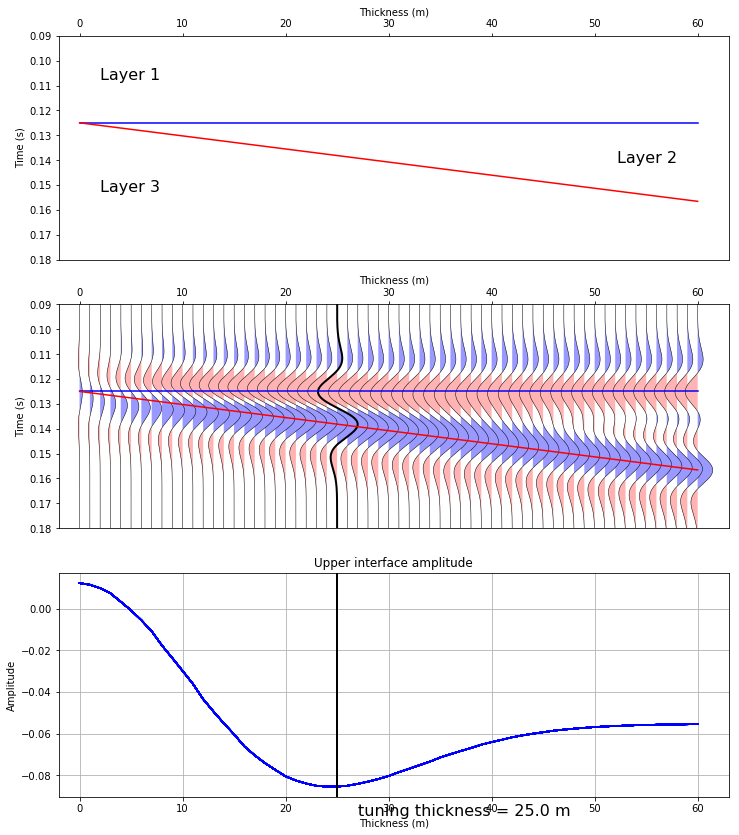

In [48]:
[ntrc, nsamp] = syn_zo.shape

fig = plt.figure(figsize=(12, 14))
fig.set_facecolor('white')

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])
ax0 = fig.add_subplot(gs[0])
ax0.plot(lyr_times[:,0], color='blue', lw=1.5)
ax0.plot(lyr_times[:,1], color='red', lw=1.5)
ax0.set_ylim((min_plot_time,max_plot_time))
ax0.invert_yaxis()
ax0.set_xlabel('Thickness (m)')
ax0.set_ylabel('Time (s)')
plt.text(2,
        min_plot_time + (lyr_times[0,0] - min_plot_time)/2.,
        'Layer 1',
        fontsize=16)
plt.text(dz_max/dz_step - 2,
        lyr_times[-1,0] + (lyr_times[-1,1] - lyr_times[-1,0])/2.,
        'Layer 2',
        fontsize=16,
        horizontalalignment='right')
plt.text(2,
        lyr_times[0,0] + (max_plot_time - lyr_times[0,0])/2.,
        'Layer 3',
        fontsize=16)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
ax0.set_xlim((-excursion, ntrc+excursion))

ax1 = fig.add_subplot(gs[1])
plot_vawig(ax1, syn_zo, t, excursion, highlight=tuning_trace)
ax1.plot(lyr_times[:,0], color='blue', lw=1.5)
ax1.plot(lyr_times[:,1], color='red', lw=1.5)
ax1.set_ylim((min_plot_time,max_plot_time))
ax1.invert_yaxis()
ax1.set_xlabel('Thickness (m)')
ax1.set_ylabel('Time (s)')

ax2 = fig.add_subplot(gs[2])
ax2.plot(syn_zo[:,lyr_indx[:,0]], color='blue')
ax2.set_xlim((-excursion, ntrc+excursion))
ax2.axvline(tuning_trace, color='k', lw=2)
ax2.grid()
ax2.set_title('Upper interface amplitude')
ax2.set_xlabel('Thickness (m)')
ax2.set_ylabel('Amplitude')
plt.text(tuning_trace + 2,
        plt.ylim()[0] * 1.1,
        'tuning thickness = {0} m'.format(str(tuning_thickness)),
        fontsize=16)

#plt.savefig('figure_1.png')
plt.show()


### Tuning affecting AVO

Since the tuning of thin beds affects the amplitude of their reflection, it is clear that thin bed responses will affect the robustness of property estimtations derived from AVO based analyses. i.e. not only will our amplitudes be affected by  

Below is a script which generates a prestack angle gather for a bed thickness defined by the user. 

#### Python script to generate a synthetic angle gather from a 3-layer property model to examine pre-stack tuning effects.

Created by:    Wes Hamlyn  
Create Date:   19-Aug-2014  
Last Mod:      5-Feb-2015  
               -addition of bandpass wavelet

This script is provided without warranty of any kind.


In [49]:
#   3-Layer Model Parameters [Layer1, Layer2, Layer 3]
vp_mod = [4016.0, 4219.0, 4255.0]  # P-wave velocity (m/s)
vs_mod = [2123.0, 2544.0, 2262.0]  # S-wave velocity (m/s)
rho_mod= [2.615, 2.479, 2.621]         # Density (g/cc)

thickness = 19.0  # vertical thickness of layer 2 in metres
calcApparentThickness = 'no'
#   Angle range for incident rays
theta1_min = 0.0    # best to leave this set to zero
theta1_max = 36.0
theta1_step= 1.0


#   Wavelet Parameters
wvlt_type = 'ricker'  # Valid values: 'ricker' or 'bandpass'
wvlt_length= 0.128 # Wavelet length in seconds
wvlt_phase = 0.0   # Wavelet phase in degrees
wvlt_scalar = 1.0  # Multiplier to scale wavelet amplitude (default = 1.0)
wvlt_cfreq = 30.0  # Ricker wavelet central frequency
f1 =  5.0          # Bandpass wavelet low truncation frequency
f2 = 10.0          # Bandpass wavelet low cut frequency
f3 = 50.0          # Bandpass wavelet high cut frequency
f4 = 65.0          # Bandpass wavelet high truncation frequency


#   Trace Parameters
tmin = 0.0
tmax = 0.5
dt = 0.0001 # changing this from 0.0001 can affect the display quality


#   Plotting Display Parameters
min_plot_time = 0.1
max_plot_time = 0.16
excursion = 2

##### Computations occur here

In [50]:
#   Some handy constants
nlayers = len(vp_mod)
nint = nlayers - 1
nangles = int( (theta1_max-theta1_min)/theta1_step + 1)


#   Generate wavelet
if wvlt_type == 'ricker':
    wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)
    
elif wvlt_type == 'bandpass':
    wvlt_t, wvlt_amp = wvlt_bpass(f1, f2, f3, f4, wvlt_phase, dt, wvlt_length)

#   Apply amplitude scale factor to wavelet (to match seismic amplitude values)
wvlt_amp = wvlt_scalar * wvlt_amp

#   Calculate reflectivities from model parameters
rc_zoep_pp = []
theta1 = []
for i in range(0, nangles):
    theta1_buf = i*theta1_step + theta1_min
    rc_buf1 = rc_zoep(vp_mod[0], vs_mod[0], rho_mod[0], vp_mod[1], vs_mod[1], rho_mod[1], theta1_buf)
    rc_buf2 = rc_zoep(vp_mod[1], vs_mod[1], rho_mod[1], vp_mod[2], vs_mod[2], rho_mod[2], theta1_buf)
    
    theta1.append(theta1_buf)
    rc_zoep_pp.append([rc_buf1[0,0], rc_buf2[0,0]])


#   Define time sample vector for output model & traces
nsamp = int((tmax-tmin)/dt) + 1
t = []
for i in range(0,nsamp):
    t.append(i*dt)


syn_zoep_pp = []
lyr_times = []
#print("\n\nStarting synthetic calcuations...\n")
for angle in range(0, nangles):
    
    dz_app = thickness
    
    #   To calculate apparent thickness of layer 2 based on incidence angle
    #   uncomment the following three rows (e.g. ray-synthetics)
    if calcApparentThickness == 'yes':
        p = ray_param(vp_mod[0], angle)
        angle2 = math.degrees(math.asin(p*vp_mod[1]))
        dz_app = thickness/math.cos(math.radians(angle2))
    
    #   Calculate interface depths
    z_int = [500.0]
    z_int.append(z_int[0] + dz_app)
    
    #   Calculate interface times
    t_int = calc_times(z_int, vp_mod)
    lyr_times.append(t_int)
    
    #   Digitize 3-layer model
    rc = digitize_model(rc_zoep_pp[angle], t_int, t)

    #   Convolve wavelet with reflectivities
    syn_buf = np.convolve(rc, wvlt_amp, mode='same')
    syn_buf = list(syn_buf)
    syn_zoep_pp.append(syn_buf)
    #print("Calculated angle %i" % (angle))


#    Convert data arrays from lists/tuples to numpy arrays    
syn_zoep_pp = np.array(syn_zoep_pp)
rc_zoep_pp = np.array(rc_zoep_pp)
t = np.array(t)


#   Calculate array indicies corresponding to top/base interfaces
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')
lyr1_indx = list(lyr_indx[:,0])
lyr2_indx = list(lyr_indx[:,1])


#   Copy convoved top/base reflectivity values to Lists for easier plotting
[ntrc, nsamp] = syn_zoep_pp.shape
line1 = []
line2 = []
for i in range(0, ntrc):
    line1.append(syn_zoep_pp[i,lyr1_indx[i]])
    line2.append(syn_zoep_pp[i,lyr2_indx[i]])



#   AVO inversion for NI and GRAD from analytic and convolved reflectivity
#   values and print the results to the command line.  Linear least squares
#   method is used for estimating NI and GRAD coefficients.
Yzoep = np.array(rc_zoep_pp[:,0])
Yzoep = Yzoep.reshape((ntrc, 1))

Yconv = np.array(line1)
Yconv = Yconv.reshape((ntrc, 1))

ones = np.ones(ntrc)
ones = ones.reshape((ntrc,1))

sintheta2 = np.sin(np.radians(np.arange(0, ntrc)))**2
sintheta2 = sintheta2.reshape((ntrc, 1))

X = np.hstack((ones, sintheta2))

#   ... matrix solution of normal equations
Azoep = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yzoep)
Aconv = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yconv)

#print('\n\n')
#print '  Method       NI         GRAD'
#print '---------------------------------'
#print ' Zoeppritz%11.5f%12.5f' % (Azoep[0], Azoep[1])
#print ' Convolved%10.5f%12.5f' % (Aconv[0], Aconv[1])


    
#   Create a "digital" time domain version of the input property model for 
#   easy plotting and comparison with the time synthetic traces
vp_dig = np.zeros(t.shape)
vs_dig = np.zeros(t.shape)
rho_dig = np.zeros(t.shape)

vp_dig[0:lyr1_indx[0]] = vp_mod[0]
vp_dig[(lyr1_indx[0]):lyr2_indx[0]] = vp_mod[1]
vp_dig[(lyr2_indx[0]):] = vp_mod[2]

vs_dig[0:lyr1_indx[0]] = vs_mod[0]
vs_dig[(lyr1_indx[0]):lyr2_indx[0]] = vs_mod[1]
vs_dig[(lyr2_indx[0]):] = vs_mod[2]

rho_dig[0:lyr1_indx[0]] = rho_mod[0]
rho_dig[(lyr1_indx[0]):lyr2_indx[0]] = rho_mod[1]
rho_dig[(lyr2_indx[0]):] = rho_mod[2]


##### Plotting happens here

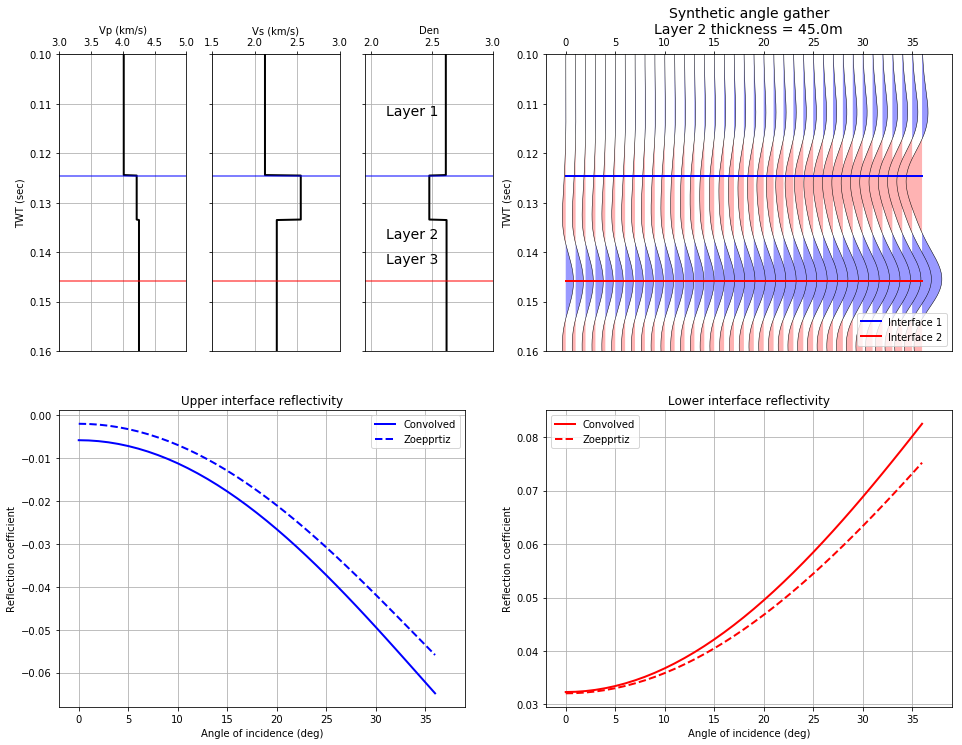

In [54]:
#   Create the plot figure
fig = plt.figure(figsize=(16, 12))
fig.set_facecolor('white')


#   Plot log curves in two-way time
ax0a = fig.add_subplot(261)
l_vp_dig, = ax0a.plot(vp_dig/1000, t, 'k', lw=2)
ax0a.set_ylim((min_plot_time,max_plot_time))
ax0a.set_xlim(3., 5.)
ax0a.invert_yaxis()
ax0a.set_ylabel('TWT (sec)')
ax0a.xaxis.tick_top()
ax0a.xaxis.set_label_position('top')
ax0a.set_xlabel('Vp (km/s)')
ax0a.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
ax0a.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
ax0a.grid()

ax0b = fig.add_subplot(262)
l_vs_dig, = ax0b.plot(vs_dig/1000, t, 'k', lw=2)
ax0b.set_ylim((min_plot_time,max_plot_time))
ax0b.set_xlim((1.5, 3.))
ax0b.invert_yaxis()
ax0b.xaxis.tick_top()
ax0b.xaxis.set_label_position('top')
ax0b.set_xlabel('Vs (km/s)')
ax0b.set_yticklabels('')
ax0b.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
ax0b.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
ax0b.grid()

ax0c = fig.add_subplot(263)
l_rho_dig, = ax0c.plot(rho_dig, t, 'k', lw=2)
ax0c.set_ylim((min_plot_time,max_plot_time))
ax0c.set_xlim((1.95, 3.))
ax0c.invert_yaxis()
ax0c.xaxis.tick_top()
ax0c.xaxis.set_label_position('top')
ax0c.set_xlabel('Den')
ax0c.set_yticklabels('')
ax0c.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
ax0c.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
ax0c.grid()

plt.text(2.55,
        min_plot_time + (lyr_times[0,0] - min_plot_time)/2.,
        'Layer 1',
        fontsize=14,
        horizontalalignment='right')
plt.text(2.55,
        lyr_times[0,1] + (lyr_times[0,0] - lyr_times[0,1])/2. + 0.002,
        'Layer 2',
        fontsize=14,
        horizontalalignment='right')
plt.text(2.55,
        lyr_times[0,0] + (max_plot_time - lyr_times[0,0])/2.,
        'Layer 3',
        fontsize=14,
        horizontalalignment='right')

#   Plot synthetic gather and model top & base interfaces in two-way time
ax1 = fig.add_subplot(222)
plot_vawig(ax1, syn_zoep_pp, t, excursion)
ax1.set_ylim((min_plot_time,max_plot_time))
l_int1, = ax1.plot(lyr_times[:,0], color='blue', lw=2)
l_int2, = ax1.plot(lyr_times[:,1], color='red', lw=2)

plt.legend([l_int1,l_int2], ['Interface 1', 'Interface 2'], loc=4)
ax1.invert_yaxis()
label_str = 'Synthetic angle gather\nLayer 2 thickness = %4.1fm' % thickness
ax1.set_xlabel(label_str, fontsize=14)
ax1.set_ylabel('TWT (sec)')


#   Plot Zoeppritz and convolved reflectivity curves    
ax2 = fig.add_subplot(2,2,3)

l_syn1, = ax2.plot(line1, color='blue', linewidth=2)
l_rc1, = ax2.plot( rc_zoep_pp[:,0], '--', color='blue', lw=2)

ax2.set_xlim((-excursion, ntrc+excursion))
ax2.grid()
ax2.set_xlabel('Angle of incidence (deg)')
ax2.set_ylabel('Reflection coefficient')
ax2.set_title('Upper interface reflectivity')
plt.legend([l_syn1, l_rc1], ['Convolved', 'Zoepprtiz'], loc=0)

ax3 = fig.add_subplot(2,2,4)
l_syn2, = ax3.plot(line2, color='red', linewidth=2)
l_rc2, = ax3.plot( rc_zoep_pp[:,1], '--', color='red', lw=2)
ax3.set_xlim((-excursion, ntrc+excursion))
ax3.grid()
ax3.set_xlabel('Angle of incidence (deg)')
ax3.set_ylabel('Reflection coefficient')
ax3.set_title('Lower interface reflectivity')
plt.legend([l_syn2, l_rc2], ['Convolved', 'Zoepprtiz'], loc=0)


#   Save the plot
#plt.savefig('ThinBedTuningEffect_AVO.png',bbox_inches = 'tight')

#   Display the plot
plt.show()


### How does the phenomenon of tuning affect our intercept and gradient plot? 

Since tuning interference will affect the amplitudes of our reflections at all angles, it will also affect our interpreted AVO repsonses. Below is the intercept vs gradient plot for the true reflectivity of a thin bed, and the composite reflectivity for different bed thicknesses, and therefore varying interference severity.

##### We will also be adding some normally distributed random noise to the idealized convolutional output in order to simulate real data

In [52]:
thickness = 5
AconvTunedIntercept = []
AconvTunedGradient = []
AconvTunedInterceptNoise = []
AconvTunedGradientNoise = []
YconvNoisyList = []
n = []

for i in range(10):
    #Some handy constants
    nlayers = len(vp_mod)
    nint = nlayers - 1
    nangles = int( (theta1_max-theta1_min)/theta1_step + 1)
    thickness = 5*i

    #   Generate wavelet
    if wvlt_type == 'ricker':
        wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)

    elif wvlt_type == 'bandpass':
        wvlt_t, wvlt_amp = wvlt_bpass(f1, f2, f3, f4, wvlt_phase, dt, wvlt_length)

    #   Apply amplitude scale factor to wavelet (to match seismic amplitude values)
    wvlt_amp = wvlt_scalar * wvlt_amp

    #   Calculate reflectivities from model parameters
    rc_zoep_pp = []
    theta1 = []
    for i in range(0, nangles):
        theta1_buf = i*theta1_step + theta1_min
        rc_buf1 = rc_zoep(vp_mod[0], vs_mod[0], rho_mod[0], vp_mod[1], vs_mod[1], rho_mod[1], theta1_buf)
        rc_buf2 = rc_zoep(vp_mod[1], vs_mod[1], rho_mod[1], vp_mod[2], vs_mod[2], rho_mod[2], theta1_buf)

        theta1.append(theta1_buf)
        rc_zoep_pp.append([rc_buf1[0,0], rc_buf2[0,0]])


    #   Define time sample vector for output model & traces
    nsamp = int((tmax-tmin)/dt) + 1
    t = []
    for i in range(0,nsamp):
        t.append(i*dt)


    syn_zoep_pp = []
    lyr_times = []
    #print("\n\nStarting synthetic calcuations...\n")
    for angle in range(0, nangles):

        dz_app = thickness

        #   To calculate apparent thickness of layer 2 based on incidence angle
        #   uncomment the following three rows (e.g. ray-synthetics)
        #p = ray_param(vp_mod[0], angle)
        #angle2 = math.degrees(math.asin(p*vp_mod[1]))
        #dz_app = thickness/math.cos(math.radians(angle2))

        #   Calculate interface depths
        z_int = [500.0]
        z_int.append(z_int[0] + dz_app)

        #   Calculate interface times
        t_int = calc_times(z_int, vp_mod)
        lyr_times.append(t_int)

        #   Digitize 3-layer model
        rc = digitize_model(rc_zoep_pp[angle], t_int, t)

        #   Convolve wavelet with reflectivities
        syn_buf = np.convolve(rc, wvlt_amp, mode='same')
        syn_buf = list(syn_buf)
        syn_zoep_pp.append(syn_buf)
        #print("Calculated angle %i" % (angle))


    #    Convert data arrays from lists/tuples to numpy arrays    
    syn_zoep_pp = np.array(syn_zoep_pp)
    rc_zoep_pp = np.array(rc_zoep_pp)
    t = np.array(t)


    #   Calculate array indicies corresponding to top/base interfaces
    lyr_times = np.array(lyr_times)
    lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')
    lyr1_indx = list(lyr_indx[:,0])
    lyr2_indx = list(lyr_indx[:,1])


    #   Copy convoved top/base reflectivity values to Lists for easier plotting
    [ntrc, nsamp] = syn_zoep_pp.shape
    line1 = []
    line2 = []
    for i in range(0, ntrc):
        line1.append(syn_zoep_pp[i,lyr1_indx[i]])
        line2.append(syn_zoep_pp[i,lyr2_indx[i]])



    #   AVO inversion for NI and GRAD from analytic and convolved reflectivity
    #   values and print the results to the command line.  Linear least squares
    #   method is used for estimating NI and GRAD coefficients.
    Yzoep = np.array(rc_zoep_pp[:,0])
    Yzoep = Yzoep.reshape((ntrc, 1))

    Yconv = np.array(line1)
    Yconv = Yconv.reshape((ntrc, 1))
    #add a bit of noise
    YconvNoisy = np.random.normal(0,np.std(Yconv)/5,len(np.arange(theta1_max+1)))
    YconvNoisy = YconvNoisy.reshape((len(YconvNoisy),1))+Yconv
    
    
    ones = np.ones(ntrc)
    ones = ones.reshape((ntrc,1))

    sintheta2 = np.sin(np.radians(np.arange(0, ntrc)))**2
    sintheta2 = sintheta2.reshape((ntrc, 1))

    X = np.hstack((ones, sintheta2))

    #   ... matrix solution of normal equations
    Azoep = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yzoep)
    Aconv = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yconv)
    AconvNoisy = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), YconvNoisy) # with noise
    
    AconvTunedIntercept.append(Aconv[0])
    AconvTunedGradient.append(Aconv[1])
    AconvTunedInterceptNoise.append(AconvNoisy[0])
    AconvTunedGradientNoise.append(AconvNoisy[1])
    n.append(thickness)
    
    

##### Plot  it all up

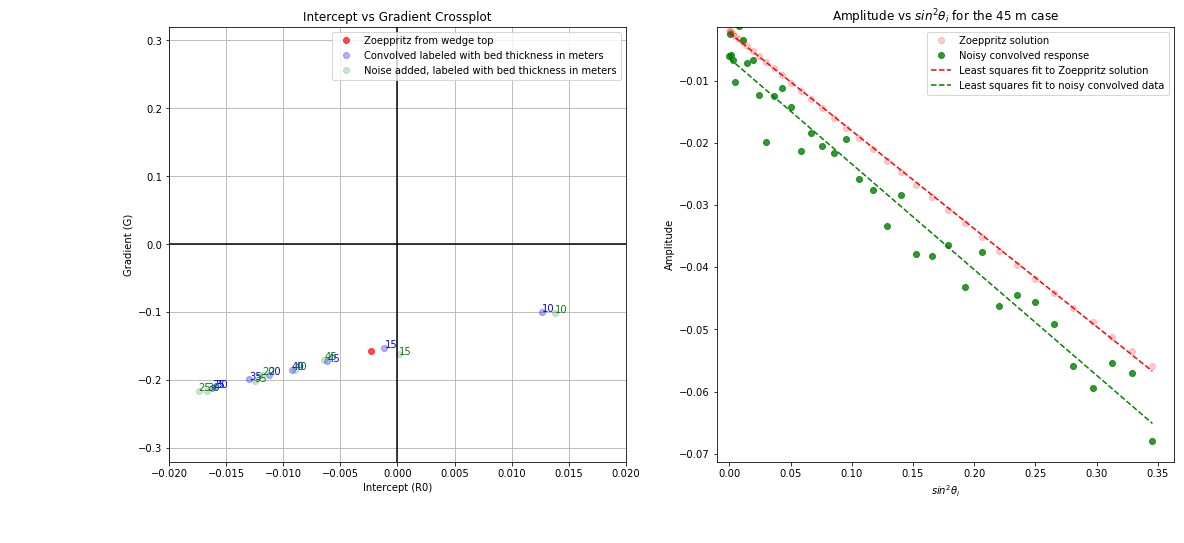

In [53]:
plt.figure(figsize = (18,8))

ax1 = plt.subplot(121)

ax1.plot(Azoep[0],Azoep[1],'ro',alpha = 0.7, label = 'Zoeppritz from wedge top')
#ax1.plot(AconvTunedIntercept, AconvTunedGradient, 'b--',alpha = 0.2, label = 'Convolved from wedge top [' + 
         #str(int(wvlt_cfreq)) + r' Hz center $f$]')
ax1.plot(AconvTunedIntercept, AconvTunedGradient, 'bo', alpha = 0.3, label = 'Convolved labeled with bed thickness in meters')
#ax1.plot(AconvTunedInterceptNoise, AconvTunedGradientNoise, 'g--',alpha = 0.2)
ax1.plot(AconvTunedInterceptNoise, AconvTunedGradientNoise, 'go', alpha = 0.2, label = 'Noise added, labeled with bed thickness in meters')
ax1.set_xlim(np.round(-Azoep[0]*10,2),np.round(Azoep[0]*10,2))
ax1.set_ylim(np.round(-Azoep[1]*2,2),np.round(Azoep[1]*2,2))
ax1.invert_yaxis()
ax1.invert_xaxis()
ax1.set_xlabel('Intercept (R0)')
ax1.set_ylabel('Gradient (G)')
ax1.set_title('Intercept vs Gradient Crossplot')
ax1.axvline(x=0,color = 'k')
ax1.axhline(y=0,color = 'k')
ax1.legend()
ax1.grid()
for i, txt in enumerate(n):
    ax1.annotate(txt, (AconvTunedIntercept[i],AconvTunedGradient[i]),color = 'blue', fontsize = 'medium')
for i, txt in enumerate(n):
    ax1.annotate(txt, (AconvTunedInterceptNoise[i],AconvTunedGradientNoise[i]), color = 'green', fontsize = 'medium')
    
axisbuffer = 1.05

ax2 = plt.subplot(122)

ax2.plot(sintheta2,Yzoep,'ro', label = 'Zoeppritz solution', alpha = 0.2)
#ax2.plot(sintheta2,Yconv,'bo', label = 'Ideal convolved amplitude response', alpha = 0.2)
ax2.plot(sintheta2,YconvNoisy,'go', label = 'Noisy convolved response', alpha = 0.8 )
ax2.set_ylim(np.min(YconvNoisy)*axisbuffer,np.max(YconvNoisy)*axisbuffer)
ax2.set_xlim(-0.01,np.max(sintheta2)*axisbuffer)
ax2.set_ylabel('Amplitude')
ax2.set_xlabel(r'$sin^{2}\theta_i$') # r sets the string input to raw so that LaTex formatting will be read properly
ax2.set_title(r'Amplitude vs $sin^2\theta_i$ for the ' + str(int(thickness)) + ' m case')
ax2.plot(sintheta2, sintheta2*Azoep[1] + Azoep[0],'r--', label = 'Least squares fit to Zoeppritz solution')
#ax2.plot(sintheta2, sintheta2*Aconv[1] + Aconv[0], 'b--', label = 'Least squares fit to idealized convolved data')
ax2.plot(sintheta2, sintheta2*AconvNoisy[1] + AconvNoisy[0],'g--', label = 'Least squares fit to noisy convolved data')
ax2.legend()